In [1]:
import quandl
import time
import yfinance as yf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from ml.database.influxdb_manager import InfluxDBOperations
from ml.features.preprocessing import calc_target, calc_indicators
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
start_date = "2000-08-01"
end_date = datetime.now().strftime('%Y-%m-%d')

# , "CORN", "SOYB" , "BZ=F"
tickers = ["GC=F", "CL=F", "EURUSD=X", "GBPUSD=X", "JPY=X", "CNY=X", "^IXIC", "^DJI", "^RUT", "^FTSE", "^GDAXI", "^FCHI", "^N225", "^HSI", "^BSESN", "^MXX", "^AXJO", "^IBEX", "SI=F", "HG=F",  "CL=F", "NG=F"] + ["^TNX", "^IRX", "^FVX", "^TYX", "SPY", "EFA"]

combined_data = pd.DataFrame()

In [3]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    combined_data[f"{ticker} Close"] = data["Close"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [4]:
nan_counts = combined_data.isna().sum()
print("Anzahl der NaN-Werte in jeder Spalte:")
print(nan_counts)

Anzahl der NaN-Werte in jeder Spalte:
GC=F Close          0
CL=F Close          1
EURUSD=X Close    839
GBPUSD=X Close    826
JPY=X Close        29
CNY=X Close       443
^IXIC Close         4
^DJI Close          4
^RUT Close          4
^FTSE Close       107
^GDAXI Close       94
^FCHI Close        57
^N225 Close       343
^HSI Close        266
^BSESN Close      277
^MXX Close        169
^AXJO Close       122
^IBEX Close        84
SI=F Close          2
HG=F Close          1
NG=F Close          1
^TNX Close          9
^IRX Close          9
^FVX Close          9
^TYX Close          9
SPY Close           4
EFA Close         252
dtype: int64


In [5]:
combined_data.interpolate(method='polynomial', order=3, inplace=True, axis=0)
combined_data.fillna(method='bfill', inplace=True)

In [6]:
combined_data

,GC=F Close,CL=F Close,EURUSD=X Close,GBPUSD=X Close,JPY=X Close,CNY=X Close,^IXIC Close,^DJI Close,^RUT Close,^FTSE Close,...,^IBEX Close,SI=F Close,HG=F Close,NG=F Close,^TNX Close,^IRX Close,^FVX Close,^TYX Close,SPY Close,EFA Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-30,273.899994,33.400002,1.196501,1.718597,106.610001,8.2768,4103.810059,11103.009766,532.330017,6615.100098,...,10869.599609,4.930000,0.8850,4.805,5.800,6.120,6.059,5.736,150.343750,42.833332
2000-08-31,278.299988,33.099998,1.196501,1.718597,106.669998,8.2768,4206.350098,11215.099609,537.890015,6672.700195,...,10884.700195,5.003000,0.8850,4.780,5.729,6.110,5.975,5.674,152.343750,42.833332
2000-09-01,277.000000,33.380001,1.196501,1.718597,105.949997,8.2768,4234.330078,11238.780273,541.909973,6795.000000,...,11170.099609,5.004000,0.8890,4.835,5.675,6.080,5.891,5.655,152.500000,42.833332
2000-09-05,275.799988,33.799999,1.196501,1.718597,105.860001,8.2768,4143.180176,11260.610352,539.020020,6752.500000,...,11188.200195,4.998000,0.9060,4.960,5.683,6.060,5.905,5.663,151.281250,42.833332
2000-09-06,274.200012,34.950001,1.196501,1.718597,105.930000,8.2768,4013.340088,11310.639648,536.320007,6694.700195,...,11238.500000,4.983000,0.9015,5.065,5.712,6.010,5.927,5.700,149.562500,42.833332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,2011.800049,74.860001,1.094044,1.260033,149.570999,7.0819,14241.019531,35333.468750,1801.150024,7460.700195,...,9936.099609,24.672001,3.7625,2.794,4.389,5.258,4.413,4.533,454.480011,72.309998
2023-11-28,2039.699951,76.410004,1.095842,1.263440,148.451996,7.1303,14281.759766,35416.980469,1792.810059,7455.200195,...,10003.400391,24.930000,3.8010,2.706,4.336,5.260,4.286,4.524,454.929993,72.330002
2023-11-29,2047.099976,77.860001,1.100594,1.271230,147.063004,7.0638,14258.490234,35430.421875,1803.810059,7423.500000,...,10062.599609,25.072001,3.7860,2.804,4.271,5.240,4.219,4.451,454.609985,72.480003


In [7]:
nan_counts = combined_data.isna().sum()
print("Anzahl der NaN-Werte in jeder Spalte:")
print(nan_counts)

Anzahl der NaN-Werte in jeder Spalte:
GC=F Close        0
CL=F Close        0
EURUSD=X Close    0
GBPUSD=X Close    0
JPY=X Close       0
CNY=X Close       0
^IXIC Close       0
^DJI Close        0
^RUT Close        0
^FTSE Close       0
^GDAXI Close      0
^FCHI Close       0
^N225 Close       0
^HSI Close        0
^BSESN Close      0
^MXX Close        0
^AXJO Close       0
^IBEX Close       0
SI=F Close        0
HG=F Close        0
NG=F Close        0
^TNX Close        0
^IRX Close        0
^FVX Close        0
^TYX Close        0
SPY Close         0
EFA Close         0
dtype: int64


In [8]:
stock_data = yf.download("^GSPC", start=start_date, end=datetime.now().strftime('%Y-%m-%d'))
stock_data = calc_target(df=stock_data)
stock_data = calc_indicators(df=stock_data)

[*********************100%%**********************]  1 of 1 completed


In [9]:
combined_data = stock_data.merge(combined_data, left_index=True, right_index=True, how='left')
combined_data.interpolate(method='polynomial', order=3, inplace=True, axis=0)
#combined_data.fillna(method='bfill', inplace=True)

In [10]:
combined_data

,Close,Volume,Target,SMA 10,EMA 10,EMA 20,WMA 10,Momentum 10,SAR,RSI,...,^IBEX Close,SI=F Close,HG=F Close,NG=F Close,^TNX Close,^IRX Close,^FVX Close,^TYX Close,SPY Close,EFA Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-09-18,1444.510010,962500000,0,1484.369006,1479.491052,1484.344255,1476.255833,-76.260010,1505.653274,35.962151,...,11188.099609,4.876000,0.9185,5.295,5.871,5.950,5.900,5.956,144.656250,42.833332
2000-09-19,1459.900024,1024900000,0,1479.651013,1475.929047,1482.016233,1471.806927,-47.179932,1496.730622,43.209946,...,11065.500000,4.883000,0.9215,5.370,5.850,5.970,5.907,5.914,145.968750,42.833332
2000-09-20,1451.339966,1104000000,0,1475.560010,1471.458305,1479.094683,1466.659464,-40.910034,1489.057141,40.466555,...,10901.299805,4.830000,0.9015,5.320,5.892,5.970,5.953,5.962,144.890625,42.833332
2000-09-21,1449.050049,1105400000,0,1470.214014,1467.384077,1476.233290,1461.839471,-53.459961,1479.759991,39.739686,...,10803.400391,4.872000,0.9255,5.287,5.871,5.960,5.945,5.927,142.687500,42.833332
2000-09-22,1448.719971,1185500000,0,1465.636011,1463.990603,1473.612974,1457.931463,-45.780029,1471.950384,39.629187,...,11029.400391,4.910000,0.9195,5.131,5.829,5.970,5.905,5.904,145.281250,42.833332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,4550.430176,3403990000,0,4518.435010,4509.047070,4448.279765,4537.410565,135.189941,4493.381238,69.712486,...,9936.099609,24.672001,3.7625,2.794,4.389,5.258,4.413,4.533,454.480011,72.309998
2023-11-28,4554.890137,3586240000,0,4532.769043,4517.382173,4458.433134,4544.038770,143.340332,4508.391025,70.126455,...,10003.400391,24.930000,3.8010,2.706,4.336,5.260,4.286,4.524,454.929993,72.330002
2023-11-29,4550.580078,4418760000,0,4538.257031,4523.418156,4467.209033,4547.277140,54.879883,4520.398855,69.142922,...,10062.599609,25.072001,3.7860,2.804,4.271,5.240,4.219,4.451,454.609985,72.480003


In [11]:
nan_counts = combined_data.isna().sum()
print("Anzahl der NaN-Werte in jeder Spalte:")
print(nan_counts)

Anzahl der NaN-Werte in jeder Spalte:
Close             0
Volume            0
Target            0
SMA 10            0
EMA 10            0
EMA 20            0
WMA 10            0
Momentum 10       0
SAR               0
RSI               0
ROC               0
%R                0
OBV               0
MACD              0
MACD_SIGNAL       0
MACD_HIST         0
CCI               0
ADOSC             0
%K                0
%D                0
+DMI              0
-DMI              0
ADX               0
up_band           0
mid_band          0
low_band          0
GC=F Close        0
CL=F Close        0
EURUSD=X Close    0
GBPUSD=X Close    0
JPY=X Close       0
CNY=X Close       0
^IXIC Close       0
^DJI Close        0
^RUT Close        0
^FTSE Close       0
^GDAXI Close      0
^FCHI Close       0
^N225 Close       0
^HSI Close        0
^BSESN Close      0
^MXX Close        0
^AXJO Close       0
^IBEX Close       0
SI=F Close        0
HG=F Close        0
NG=F Close        0
^TNX Close        0
^I

In [12]:
X = combined_data.drop(['Target'], axis=1)
train_x, test_x, train_y, test_y = train_test_split(X, combined_data['Target'], test_size=0.20, shuffle=True,random_state=42)
scaler = StandardScaler()
train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

In [14]:
#Modellname: ExtraTreesClassifier
# Genauigkeit:  0.9203767123287672

etc = ExtraTreesClassifier(n_estimators=2000, random_state=42)
etc.fit(train_x, train_y)
y_pred = etc.predict(test_x)
accuracy = accuracy_score(test_y, y_pred)
print(f"Modellname: {etc.__class__.__name__}")
print(f"Genauigkeit: {accuracy}")

Modellname: ExtraTreesClassifier
Genauigkeit: 0.9203767123287672


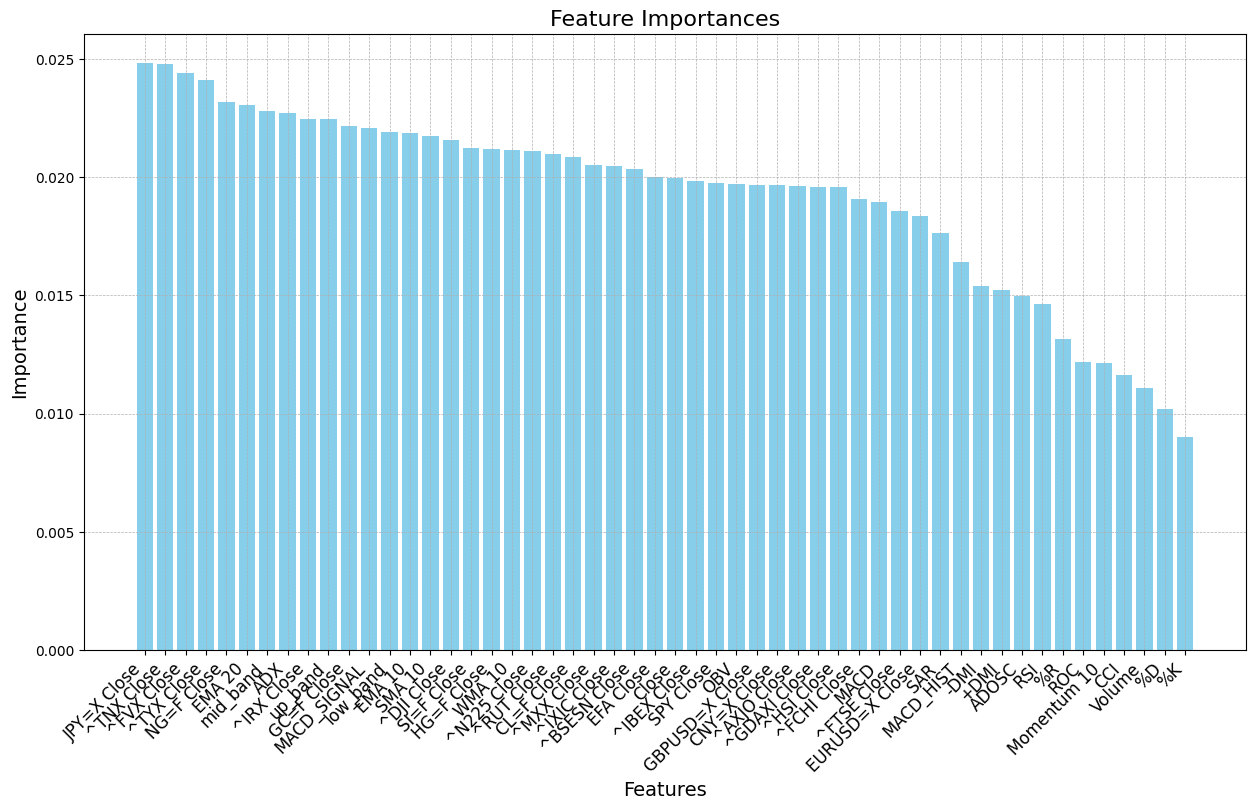

In [15]:
import matplotlib.pyplot as plt
import numpy as np

importances = etc.feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]
sorted_feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(15, 8))  # Größeres Plot-Fenster
plt.title("Feature Importances", fontsize=16)
plt.bar(range(X.shape[1]), importances[indices], color='skyblue')  # Farbige Balken

# x-Achsenbeschriftungen schräg und lesbar einstellen
plt.xticks(range(X.shape[1]), sorted_feature_names, rotation=45, ha='right', fontsize=12)

# Gitterlinien für bessere Lesbarkeit
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Achsenbeschriftungen
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)

plt.show()


In [176]:
start_date = stock_data.index.min().strftime('%Y-%m-%d')
end_date = stock_data.index.max().strftime('%Y-%m-%d')

quandl.ApiConfig.api_key = 'Wy8ZWQS9rkyJKyuiVu4G'
USTREASURY = quandl.get('USTREASURY/REALLONGTERM',start_date=start_date,end_date=end_date)
time.sleep(10)
MULTPL = quandl.get('MULTPL/SP500_DIV_YIELD_MONTH',start_date=start_date,end_date=end_date)

In [177]:
combined_data = stock_data.merge(USTREASURY, left_index=True, right_index=True, how='left')
#combined_data = stock_data.merge(MULTPL, left_index=True, right_index=True, how='left')

nan_counts = combined_data.isna().sum()
print("Anzahl der NaN-Werte in jeder Spalte:")
print(nan_counts)

combined_data.interpolate(method='linear', inplace=True)

Anzahl der NaN-Werte in jeder Spalte:
Close                        0
Volume                       0
Target                       0
Rendite                      0
SMA 10                       0
EMA 10                       0
EMA 20                       0
WMA 10                       0
Momentum 10                  0
SAR                          0
RSI                          0
ROC                          0
%R                           0
OBV                          0
MACD                         0
MACD_SIGNAL                  0
MACD_HIST                    0
CCI                          0
ADOSC                        0
%K                           0
%D                           0
+DMI                         0
-DMI                         0
ADX                          0
up_band                      0
mid_band                     0
low_band                     0
LT Real Average (>10Yrs)    44
dtype: int64
